## Setup the requirements

In [ ]:
!pip install torch torchaudio torchvision mlflow dagshub optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260

In [ ]:
import mlflow
import dagshub
import json

# Load JSON from file
with open('/content/youtube_dagshub.json', 'r', encoding='utf-8') as f:
    token = json.load(f)

DAGSHUB_USER="Prayesh13"
DAGSHUB_REPO="youtube-comments-analysis"


mlflow.set_tracking_uri(f"https://dagshub.com/{DAGSHUB_USER}/{DAGSHUB_REPO}.mlflow")
dagshub.auth.add_app_token(token['youtube_dagshub'])
dagshub.init(repo_owner='Prayesh13', repo_name='youtube-comments-analysis', mlflow=True, )


Accessing as Prayesh13

Initialized MLflow to track repo "Prayesh13/youtube-comments-analysis"

Repository Prayesh13/youtube-comments-analysis initialized!

🏃 View run grandiose-finch-574 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/0/runs/bca2045f2a124fd4a719089a140c5f5a
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/0


## Baseline Model

In [ ]:
import numpy as np
import pandas as pd
import os

import mlflow
import mlflow.sklearn
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Step 1: Load the Processed dataset

df = pd.read_csv("/content/sentiment_processed.csv")



### Bi - LSTM Model

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
X = df['content']
y = df['label']
y = y + 1

y = y.astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import re
from collections import Counter

# Custom tokenizer using regex (no downloads required)
def tokenizer(text):
    return re.findall(r'\b\w+\b', text.lower())

# Build vocabulary manually
def build_vocab(texts, min_freq=1):
    counter = Counter()
    for text in texts:
        counter.update(tokenizer(text))
    vocab = {"<unk>": 0, "<pad>": 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

# Usage
print("Building vocabulary...")
vocab = build_vocab(X_train)
print(f"Vocabulary size: {len(vocab)}")


Building vocabulary...
Vocabulary size: 101852


In [ ]:
mlflow.set_experiment("LSTM_Text_Classification")

<Experiment: artifact_location='mlflow-artifacts:/02ca759d4d84448baac8a9432ef1b410', creation_time=1744814347543, experiment_id='2', last_update_time=1744814347543, lifecycle_stage='active', name='LSTM_Text_Classification', tags={}>

In [ ]:
# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, tokenizer, max_len=100):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.tokenizer(self.texts[idx])
        ids = [self.vocab.get(token, self.vocab["<unk>"]) for token in tokens][:self.max_len]
        ids += [self.vocab["<pad>"]] * (self.max_len - len(ids))
        return torch.tensor(ids), torch.tensor(self.labels[idx])

# DataLoader
print("Preparing DataLoaders...")
train_dataset = TextDataset(X_train.tolist(), y_train.tolist(), vocab, tokenizer)
test_dataset = TextDataset(X_test.tolist(), y_test.tolist(), vocab, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

Preparing DataLoaders...


In [ ]:
# BiLSTM Model
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<pad>"])
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # hidden_dim * 2 because of bidirectional

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        # hidden shape: (num_layers * num_directions, batch_size, hidden_dim)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # Concatenate last forward & backward hidden states
        return self.fc(hidden)


In [ ]:
print(y_train.unique())
print(y_test.unique())

device = torch.device('cpu')  # 👈 debug on CPU first!

[2 1 0]
[1 2 0]


Starting training...

Epoch 1 Completed | Avg Loss: 0.4959
Epoch 2 Completed | Avg Loss: 0.2792
Epoch 3 Completed | Avg Loss: 0.2037
Epoch 4 Completed | Avg Loss: 0.1450
Epoch 5 Completed | Avg Loss: 0.0955
Starting evaluation...


Test Accuracy: 0.8956

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      8791
           1       0.90      0.93      0.91     13494
           2       0.92      0.90      0.91     17609

    accuracy                           0.90     39894
   macro avg       0.89      0.89      0.89     39894
weighted avg       0.90      0.90      0.90     39894



2025/04/18 03:59:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 03:59:55 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 03:59:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Bi-LSTM Baseline at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/4/runs/569d3b0dcd5742f18e3b603f6d9bd59c
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/4


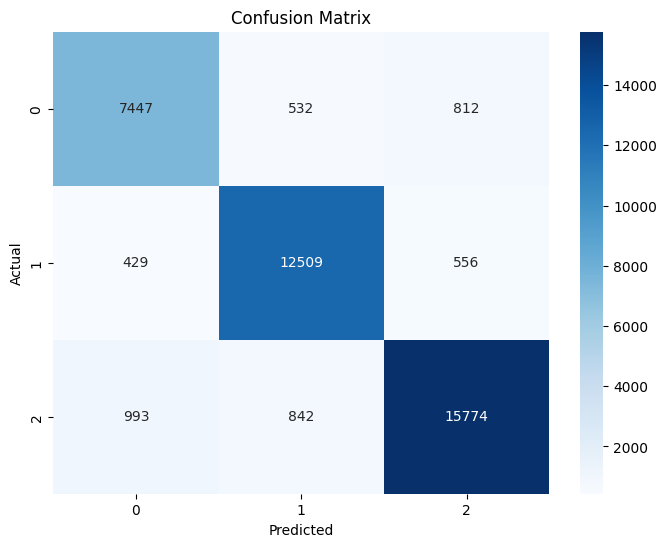

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow
import mlflow.pytorch

mlflow.set_experiment("Baseline Experiment")
with mlflow.start_run(run_name="Bi-LSTM Baseline"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vocab_size = len(vocab)
    embed_dim = 150
    hidden_dim = 128
    output_dim = y_train.nunique()

    model = BiLSTMModel(vocab_size, embed_dim, hidden_dim, output_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Log hyperparameters
    mlflow.log_param("vocab_size", vocab_size)
    mlflow.log_param("embed_dim", embed_dim)
    mlflow.log_param("hidden_dim", hidden_dim)
    mlflow.log_param("output_dim", output_dim)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("epochs", 5)

    print("Starting training...\n")
    for epoch in range(1, 6):
        model.train()
        total_loss = 0
        batch_count = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_batch = y_batch.long()

            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            batch_count += 1
        avg_loss = total_loss / batch_count
        print(f"Epoch {epoch} Completed | Avg Loss: {avg_loss:.4f}")
        mlflow.log_metric("train_loss", avg_loss, step=epoch)

    print("Starting evaluation...\n")
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(test_loader):
            X_batch = X_batch.to(device)
            output = model(X_batch)
            preds = torch.argmax(output, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())

    # Accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nTest Accuracy: {accuracy:.4f}")
    mlflow.log_metric("test_accuracy", accuracy)

    # Classification Report
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, output_dict=True)
    print(classification_report(all_labels, all_preds))

    # Log each metric separately to MLflow
    for label, metrics in report.items():
        if isinstance(metrics, dict):  # skip 'accuracy' because it's not a dict
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Save and log the model
    mlflow.pytorch.log_model(model, "models/lstm_model")


In [ ]:
print("y_train unique:", np.unique(y_train))
print("y_test unique:", np.unique(y_test))
print("output_dim:", output_dim)
print("y_train dtype:", y_train.dtype)
print("y_test dtype:", y_test.dtype)


y_train unique: [0 1 2]
y_test unique: [0 1 2]
output_dim: 3
y_train dtype: int64
y_test dtype: int64


### Bi-LSTM Model with attention

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
X = df['content']
y = df['label']
y = y + 1

y = y.astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import re
from collections import Counter

# Custom tokenizer using regex (no downloads required)
def tokenizer(text):
    return re.findall(r'\b\w+\b', text.lower())

# Build vocabulary manually
def build_vocab(texts, min_freq=1):
    counter = Counter()
    for text in texts:
        counter.update(tokenizer(text))
    vocab = {"<unk>": 0, "<pad>": 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

# Usage
print("Building vocabulary...")
vocab = build_vocab(X_train)
print(f"Vocabulary size: {len(vocab)}")


Building vocabulary...
Vocabulary size: 101852


In [ ]:
# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, tokenizer, max_len=100):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.tokenizer(self.texts[idx])
        ids = [self.vocab.get(token, self.vocab["<unk>"]) for token in tokens][:self.max_len]
        ids += [self.vocab["<pad>"]] * (self.max_len - len(ids))
        return torch.tensor(ids), torch.tensor(self.labels[idx])

# DataLoader
print("Preparing DataLoaders...")
train_dataset = TextDataset(X_train.tolist(), y_train.tolist(), vocab, tokenizer)
test_dataset = TextDataset(X_test.tolist(), y_test.tolist(), vocab, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

Preparing DataLoaders...


In [ ]:
# BiLSTM Model
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<pad>"])
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # hidden_dim * 2 because of bidirectional

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        # hidden shape: (num_layers * num_directions, batch_size, hidden_dim)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # Concatenate last forward & backward hidden states
        return self.fc(hidden)


In [ ]:
print(y_train.unique())
print(y_test.unique())

device = torch.device('cpu')  # 👈 debug on CPU first!

[2 1 0]
[1 2 0]


Starting training...

Epoch 1 Completed | Avg Loss: 0.5043
Epoch 2 Completed | Avg Loss: 0.2780
Epoch 3 Completed | Avg Loss: 0.2021
Epoch 4 Completed | Avg Loss: 0.1439
Epoch 5 Completed | Avg Loss: 0.0942
Epoch 6 Completed | Avg Loss: 0.0628
Epoch 7 Completed | Avg Loss: 0.0422
Epoch 8 Completed | Avg Loss: 0.0282
Epoch 9 Completed | Avg Loss: 0.0246
Epoch 10 Completed | Avg Loss: 0.0232
Starting evaluation...


Test Accuracy: 0.8863

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      8791
           1       0.90      0.90      0.90     13494
           2       0.90      0.90      0.90     17609

    accuracy                           0.89     39894
   macro avg       0.88      0.88      0.88     39894
weighted avg       0.89      0.89      0.89     39894



2025/04/18 08:03:05 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 08:03:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 08:03:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Bi-LSTM with Attention Baseline at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/4/runs/6f81db86611e42d5942ba0a05d1d7218
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/4


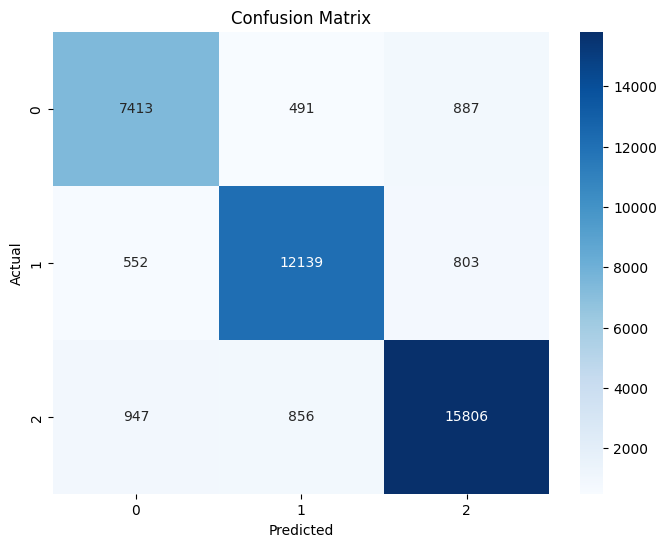

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow
import mlflow.pytorch

mlflow.set_experiment("Baseline Experiment")
with mlflow.start_run(run_name="Bi-LSTM with Attention Baseline"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vocab_size = len(vocab)
    embed_dim = 150
    hidden_dim = 128
    output_dim = y_train.nunique()

    model = BiLSTMModel(vocab_size, embed_dim, hidden_dim, output_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Log hyperparameters
    mlflow.log_param("vocab_size", vocab_size)
    mlflow.log_param("embed_dim", embed_dim)
    mlflow.log_param("hidden_dim", hidden_dim)
    mlflow.log_param("output_dim", output_dim)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("epochs", 5)

    print("Starting training...\n")
    for epoch in range(1, 11):
        model.train()
        total_loss = 0
        batch_count = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_batch = y_batch.long()

            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            batch_count += 1
        avg_loss = total_loss / batch_count
        print(f"Epoch {epoch} Completed | Avg Loss: {avg_loss:.4f}")
        mlflow.log_metric("train_loss", avg_loss, step=epoch)

    print("Starting evaluation...\n")
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(test_loader):
            X_batch = X_batch.to(device)
            output = model(X_batch)
            preds = torch.argmax(output, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())

    # Accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nTest Accuracy: {accuracy:.4f}")
    mlflow.log_metric("test_accuracy", accuracy)

    # Classification Report
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, output_dict=True)
    print(classification_report(all_labels, all_preds))

    # Log each metric separately to MLflow
    for label, metrics in report.items():
        if isinstance(metrics, dict):  # skip 'accuracy' because it's not a dict
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Save and log the model
    mlflow.pytorch.log_model(model, "models/lstm_model")


In [ ]:
print(report)

### Final Code of Bi-LSTM Model with attention mechanism

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
X = df['content']
y = df['label']
y = y + 1

y = y.astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import re
from collections import Counter

# Custom tokenizer using regex (no downloads required)
def tokenizer(text):
    return re.findall(r'\b\w+\b', text.lower())

# Build vocabulary manually
def build_vocab(texts, min_freq=1):
    counter = Counter()
    for text in texts:
        counter.update(tokenizer(text))
    vocab = {"<unk>": 0, "<pad>": 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

# Usage
print("Building vocabulary...")
vocab = build_vocab(X_train)
print(f"Vocabulary size: {len(vocab)}")


Building vocabulary...
Vocabulary size: 101852


In [ ]:
from torch.utils.data import DataLoader, Dataset

def create_loaders(X_train, y_train, X_test, y_test, vocab, tokenizer, batch_size=32, max_len=100):
    class TextDataset(Dataset):
        def __init__(self, texts, labels, vocab, tokenizer, max_len=100):
            self.texts = texts
            self.labels = labels
            self.vocab = vocab
            self.tokenizer = tokenizer
            self.max_len = max_len

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            tokens = self.tokenizer(self.texts[idx])
            ids = [self.vocab.get(token, self.vocab["<unk>"]) for token in tokens][:self.max_len]
            ids += [self.vocab["<pad>"]] * (self.max_len - len(ids))
            return torch.tensor(ids), torch.tensor(self.labels[idx])

    # Create datasets
    train_dataset = TextDataset(X_train.tolist(), y_train.tolist(), vocab, tokenizer, max_len)
    test_dataset = TextDataset(X_test.tolist(), y_test.tolist(), vocab, tokenizer, max_len)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader


In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Attention Layer
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim * 2, 1)

    def forward(self, lstm_output):
        attn_weights = torch.softmax(self.attention(lstm_output), dim=1)
        context = torch.sum(attn_weights * lstm_output, dim=1)
        return context

In [ ]:
# 2. BiLSTM + Attention Model
class BiLSTMAttentionModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(BiLSTMAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<pad>"])
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        attn_output = self.attention(lstm_out)
        return self.fc(attn_output)

In [ ]:
# 3. Train Model Function
def train_model(model, train_loader, val_loader, optimizer, criterion, device, trial_number):
    best_val_loss = np.inf
    patience_counter = 0
    patience = 3
    num_epochs = 20

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        mlflow.log_metric("train_loss", avg_train_loss, step=epoch)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        mlflow.log_metric("val_loss", avg_val_loss, step=epoch)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_trial{trial_number}.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    return model

In [ ]:
# 4. Function to Log Parameters
def log_params(trial):
    params = {
        "embed_dim": trial.params["embed_dim"],
        "hidden_dim": trial.params["hidden_dim"],
        "learning_rate": trial.params["learning_rate"],
        "batch_size": trial.params["batch_size"]
    }
    mlflow.log_params(params)

In [ ]:
# 6. Function to Log Metrics and Artifacts
def log_metrics_artifacts(accuracy, report, conf_matrix, trial_number, model):
    mlflow.log_metric("test_accuracy", accuracy)

    # Log detailed classification report
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)

    # Save confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    conf_matrix_path = f"confusion_matrix_trial{trial_number}.png"
    plt.savefig(conf_matrix_path)
    mlflow.log_artifact(conf_matrix_path)

    # Log model
    mlflow.pytorch.log_model(model, "models/bilstm_attention_model")

In [ ]:
# 5. Function to Evaluate Model
def evaluate_model(model, dataloader):
    device = next(model.parameters()).device
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            output = model(X_batch)
            preds = torch.argmax(output, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, output_dict=True)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return accuracy, report, conf_matrix

In [ ]:
# 7. Objective Function
def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    embed_dim = trial.suggest_categorical('embed_dim', [100, 150, 200])
    hidden_dim = trial.suggest_categorical('hidden_dim', [128, 256, 512])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    model = BiLSTMAttentionModel(
        vocab_size=len(vocab),
        embed_dim=embed_dim,
        hidden_dim=hidden_dim,
        output_dim=y_train.nunique()
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader, test_loader = create_loaders(X_train, y_train, X_test, y_test, vocab, tokenizer, batch_size=32, max_len=100)

    mlflow.set_experiment("BiLSTM Attention Optuna Tuning")
    with mlflow.start_run(run_name=f"Trial_{trial.number}"):
        log_params(trial)

        model = train_model(model, train_loader, test_loader, optimizer, criterion, device, trial.number)
        model.load_state_dict(torch.load(f"best_model_trial{trial.number}.pth"))

        accuracy, report, conf_matrix = evaluate_model(model, test_loader)
        log_metrics_artifacts(accuracy, report, conf_matrix, trial.number, model)

    return 1.0 - accuracy  # minimize

In [ ]:
# 8. Run the Study
def run_optuna_study(n_trials=20):
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    best_accuracy = 1.0 - study.best_value

    print("Best hyperparameters:", best_params)
    print("Best accuracy:", best_accuracy)

    return study


[I 2025-04-18 08:19:48,134] A new study created in memory with name: no-name-ae86518e-9c42-4ed5-882c-ec77a01bf9fd
2025/04/18 08:19:49 INFO mlflow.tracking.fluent: Experiment with name 'BiLSTM Attention Optuna Tuning' does not exist. Creating a new experiment.
2025/04/18 08:37:35 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 08:37:40 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_req

🏃 View run Trial_0 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6/runs/a3819134d6e0496e880ef8e43925ebb8
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6


[I 2025-04-18 08:37:53,443] Trial 0 finished with value: 0.11224745575775807 and parameters: {'embed_dim': 150, 'hidden_dim': 512, 'learning_rate': 0.000363337681832297, 'batch_size': 64}. Best is trial 0 with value: 0.11224745575775807.
2025/04/18 08:51:30 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 08:51:35 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18

🏃 View run Trial_1 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6/runs/a3b242f23aed4370ba40b8703fa41b56
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6


[I 2025-04-18 08:51:45,898] Trial 1 finished with value: 0.1197172507143931 and parameters: {'embed_dim': 100, 'hidden_dim': 512, 'learning_rate': 0.00035139782878729377, 'batch_size': 128}. Best is trial 0 with value: 0.11224745575775807.
2025/04/18 08:58:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 08:58:35 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/

🏃 View run Trial_2 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6/runs/e08a4218c2264fa087e03dc15702b7ee
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6


[I 2025-04-18 08:58:49,447] Trial 2 finished with value: 0.11086880232616436 and parameters: {'embed_dim': 200, 'hidden_dim': 256, 'learning_rate': 0.008644671294092262, 'batch_size': 32}. Best is trial 2 with value: 0.11086880232616436.
2025/04/18 09:05:14 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 09:05:18 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18

🏃 View run Trial_3 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6/runs/b4705682766443c680e09faee597c1fb
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6


[I 2025-04-18 09:05:28,265] Trial 3 finished with value: 0.09550308317040157 and parameters: {'embed_dim': 100, 'hidden_dim': 256, 'learning_rate': 0.006059999848518593, 'batch_size': 128}. Best is trial 3 with value: 0.09550308317040157.
2025/04/18 09:26:06 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 09:26:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/1

🏃 View run Trial_4 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6/runs/9c0c18e4e2ce413892df114ef181cbcc
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6


[I 2025-04-18 09:26:25,732] Trial 4 finished with value: 0.11518022760314839 and parameters: {'embed_dim': 150, 'hidden_dim': 512, 'learning_rate': 0.00012154590097701201, 'batch_size': 64}. Best is trial 3 with value: 0.09550308317040157.
2025/04/18 09:40:02 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 09:40:06 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/

🏃 View run Trial_5 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6/runs/4b2deba65277404aa55876f372511218
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6


[I 2025-04-18 09:40:17,497] Trial 5 finished with value: 0.1021958189201384 and parameters: {'embed_dim': 100, 'hidden_dim': 512, 'learning_rate': 0.0010185546806621118, 'batch_size': 32}. Best is trial 3 with value: 0.09550308317040157.
2025/04/18 09:50:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 09:50:35 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18

🏃 View run Trial_6 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6/runs/354b6026cd8b4c71a8bb301f53ef98c6
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6


[I 2025-04-18 09:50:46,088] Trial 6 finished with value: 0.11465383265653983 and parameters: {'embed_dim': 150, 'hidden_dim': 256, 'learning_rate': 0.000154397282420411, 'batch_size': 128}. Best is trial 3 with value: 0.09550308317040157.
2025/04/18 10:04:21 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 10:04:26 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/1

🏃 View run Trial_7 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6/runs/cd4fcc2f28354f828f44bdc1203730fc
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6


[I 2025-04-18 10:04:36,782] Trial 7 finished with value: 0.09319697197573573 and parameters: {'embed_dim': 100, 'hidden_dim': 512, 'learning_rate': 0.0013019582882712094, 'batch_size': 32}. Best is trial 7 with value: 0.09319697197573573.
2025/04/18 10:14:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 10:14:36 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/1

🏃 View run Trial_8 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6/runs/9431e14346fa4f438b16fb07056b93ec
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6


[I 2025-04-18 10:14:48,717] Trial 8 finished with value: 0.09978944202135664 and parameters: {'embed_dim': 200, 'hidden_dim': 256, 'learning_rate': 0.0002768948249183031, 'batch_size': 32}. Best is trial 7 with value: 0.09319697197573573.
2025/04/18 10:19:27 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 10:19:32 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/1

🏃 View run Trial_9 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6/runs/1cdfe7d996b641b7827d10e06ccb6198
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6


[I 2025-04-18 10:19:45,562] Trial 9 finished with value: 0.09349776908808338 and parameters: {'embed_dim': 200, 'hidden_dim': 128, 'learning_rate': 0.0023431213631794684, 'batch_size': 64}. Best is trial 7 with value: 0.09319697197573573.
2025/04/18 10:23:54 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 10:23:58 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/1

🏃 View run Trial_10 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6/runs/ff92baf8312a41678a67fd130475d319
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6


[I 2025-04-18 10:24:08,241] Trial 10 finished with value: 0.09241991276883743 and parameters: {'embed_dim': 100, 'hidden_dim': 128, 'learning_rate': 0.0015592818635430038, 'batch_size': 32}. Best is trial 10 with value: 0.09241991276883743.
2025/04/18 10:28:16 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 10:28:21 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04

🏃 View run Trial_11 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6/runs/af0cc60c476b49379b65f5a8a002b159
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6


[I 2025-04-18 10:28:31,551] Trial 11 finished with value: 0.08865994886449091 and parameters: {'embed_dim': 100, 'hidden_dim': 128, 'learning_rate': 0.0015497926097668433, 'batch_size': 32}. Best is trial 11 with value: 0.08865994886449091.
2025/04/18 10:32:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 10:32:46 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04

🏃 View run Trial_12 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6/runs/15929d301ada4bd986d408997f6ebdf5
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6


[I 2025-04-18 10:32:55,678] Trial 12 finished with value: 0.08823381962199828 and parameters: {'embed_dim': 100, 'hidden_dim': 128, 'learning_rate': 0.00274134071928009, 'batch_size': 32}. Best is trial 12 with value: 0.08823381962199828.
2025/04/18 10:37:07 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 10:37:11 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/1

🏃 View run Trial_13 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6/runs/565a448c1aa2475bb0b27f1f0f6b1ae0
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6


[I 2025-04-18 10:37:21,482] Trial 13 finished with value: 0.0898882037399108 and parameters: {'embed_dim': 100, 'hidden_dim': 128, 'learning_rate': 0.0031522601333976432, 'batch_size': 32}. Best is trial 12 with value: 0.08823381962199828.
2025/04/18 10:41:32 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 10:41:36 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/

🏃 View run Trial_14 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6/runs/cd95e63087604c6382708b1bd93ad923
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6


[I 2025-04-18 10:41:46,945] Trial 14 finished with value: 0.09021406727828751 and parameters: {'embed_dim': 100, 'hidden_dim': 128, 'learning_rate': 0.003349194549488314, 'batch_size': 32}. Best is trial 12 with value: 0.08823381962199828.
2025/04/18 10:46:00 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 10:46:05 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/

🏃 View run Trial_15 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6/runs/0358692ec36a4a1182ab78ee00bb3343
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6


[I 2025-04-18 10:46:12,981] Trial 15 finished with value: 0.10307314383115251 and parameters: {'embed_dim': 100, 'hidden_dim': 128, 'learning_rate': 0.000610562616598492, 'batch_size': 32}. Best is trial 12 with value: 0.08823381962199828.
2025/04/18 10:50:23 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 10:50:27 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/

🏃 View run Trial_16 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6/runs/6c2f18c6eb2148edb7964f1da349a6e2
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6


[I 2025-04-18 10:50:36,152] Trial 16 finished with value: 0.0990374492404873 and parameters: {'embed_dim': 100, 'hidden_dim': 128, 'learning_rate': 0.0006854546858165513, 'batch_size': 32}. Best is trial 12 with value: 0.08823381962199828.
2025/04/18 10:53:58 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 10:54:03 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/

🏃 View run Trial_17 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6/runs/4155d095b6e5419392d657dc37679c55
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6


[I 2025-04-18 10:54:11,674] Trial 17 finished with value: 0.09134205644959137 and parameters: {'embed_dim': 100, 'hidden_dim': 128, 'learning_rate': 0.004511248759875619, 'batch_size': 32}. Best is trial 12 with value: 0.08823381962199828.
2025/04/18 10:59:56 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 11:00:01 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/

🏃 View run Trial_18 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6/runs/ba966794d4ab4f1ea0254ee8eac55c9b
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6


[I 2025-04-18 11:00:13,816] Trial 18 finished with value: 0.0883340853261142 and parameters: {'embed_dim': 200, 'hidden_dim': 128, 'learning_rate': 0.0017868430367041078, 'batch_size': 128}. Best is trial 12 with value: 0.08823381962199828.
2025/04/18 11:06:00 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 11:06:05 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04

🏃 View run Trial_19 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6/runs/b21b53ea83f24d1fa92c0116d1f7f960
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/6


[I 2025-04-18 11:06:17,815] Trial 19 finished with value: 0.08996340301799766 and parameters: {'embed_dim': 200, 'hidden_dim': 128, 'learning_rate': 0.001991457971029114, 'batch_size': 128}. Best is trial 12 with value: 0.08823381962199828.


Best hyperparameters: {'embed_dim': 100, 'hidden_dim': 128, 'learning_rate': 0.00274134071928009, 'batch_size': 32}
Best accuracy: 0.9117661803780017


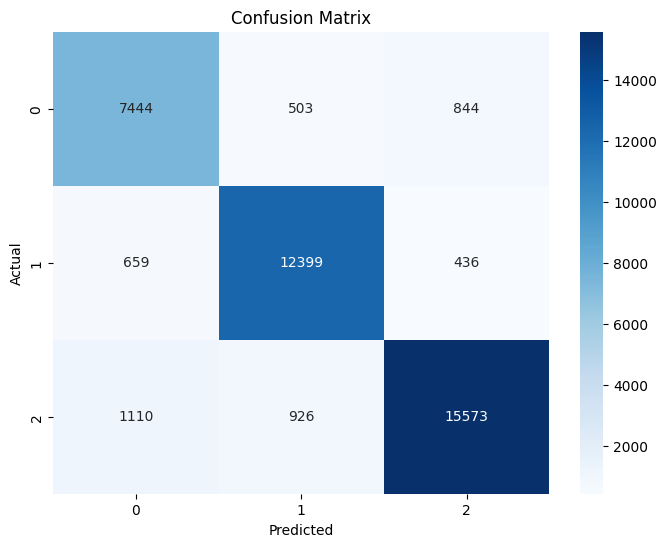

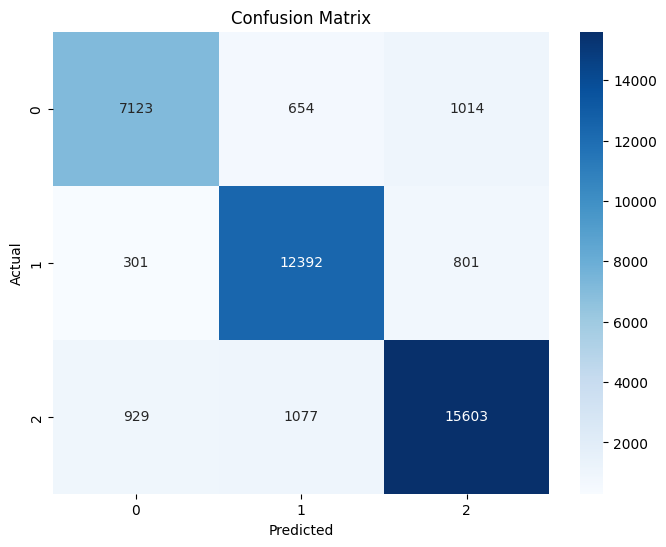

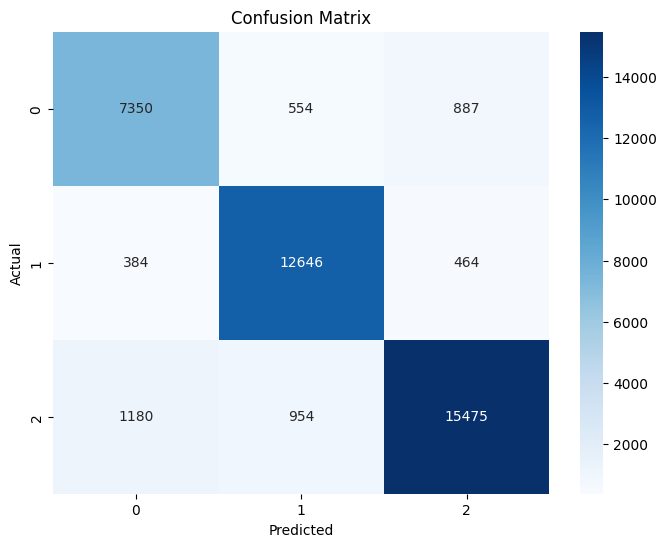

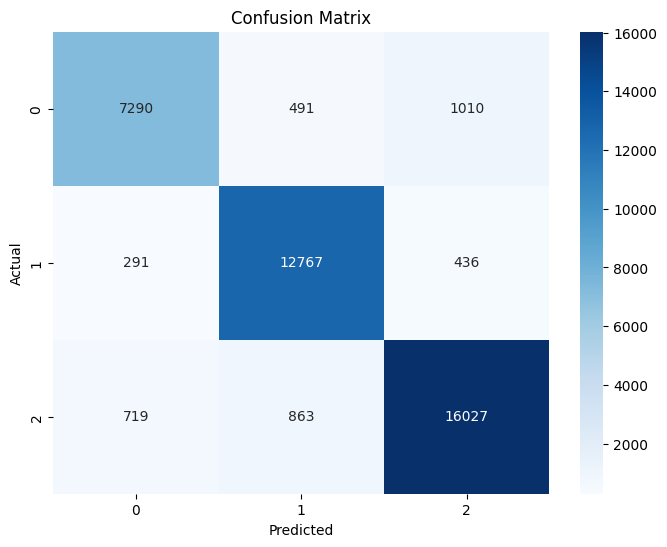

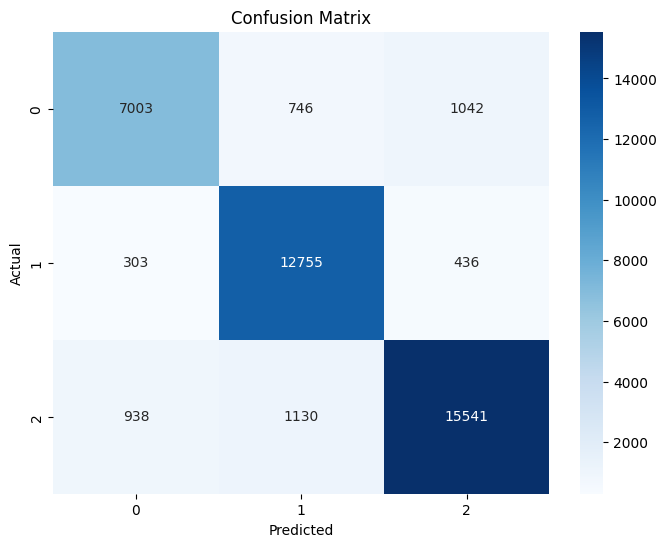

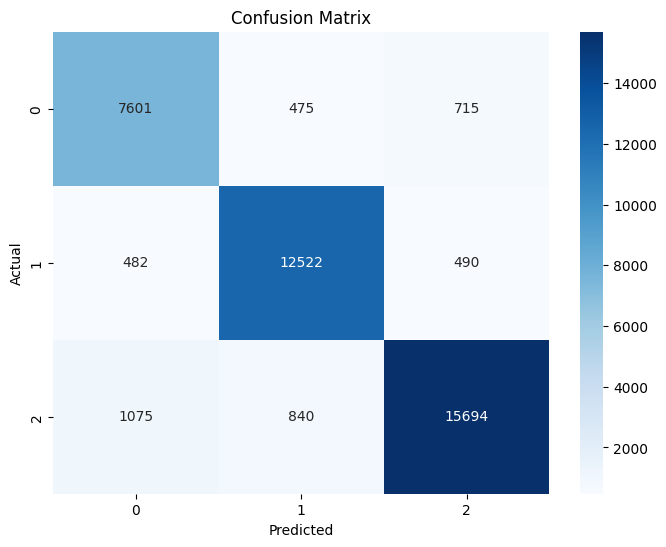

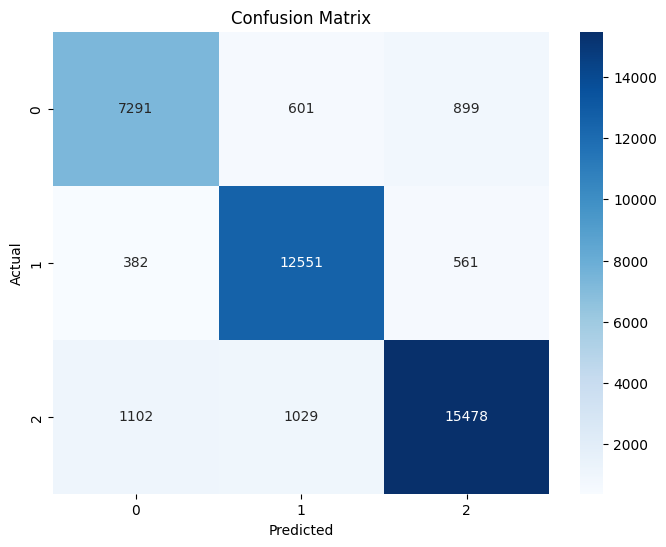

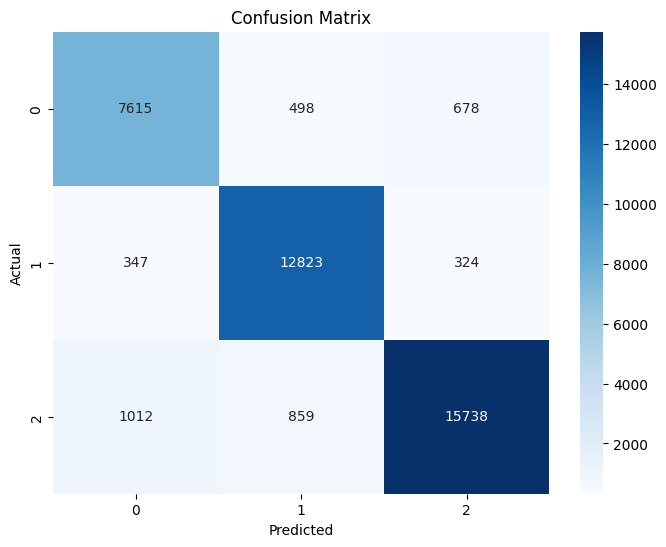

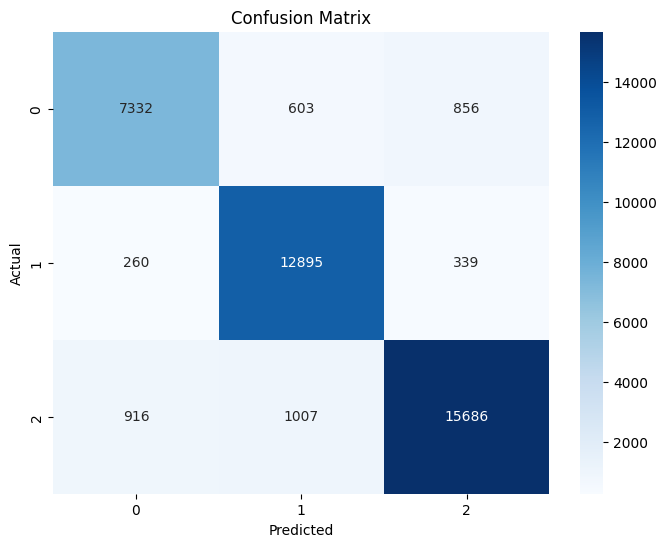

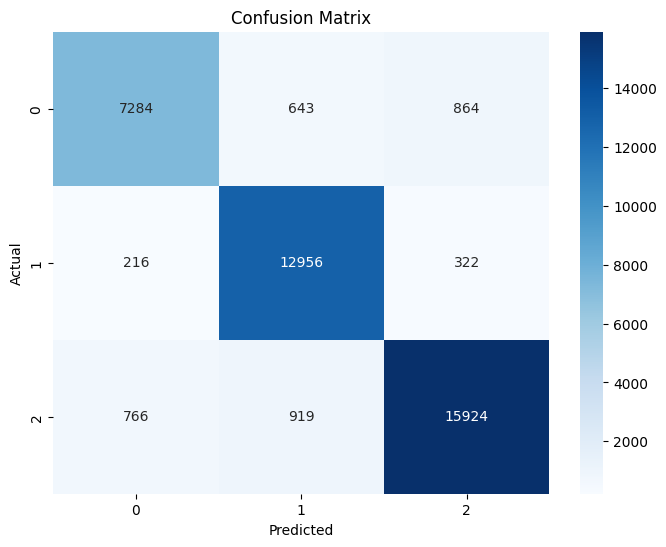

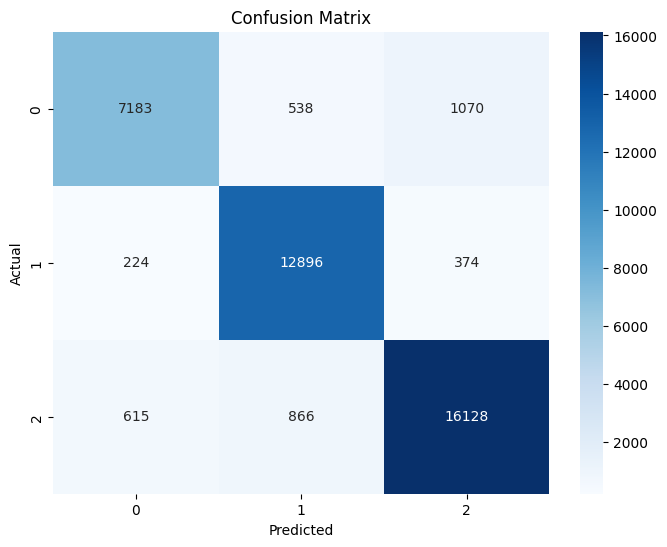

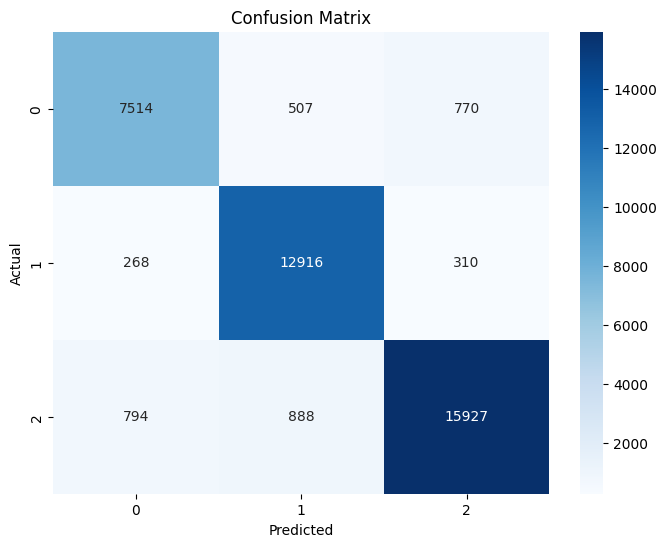

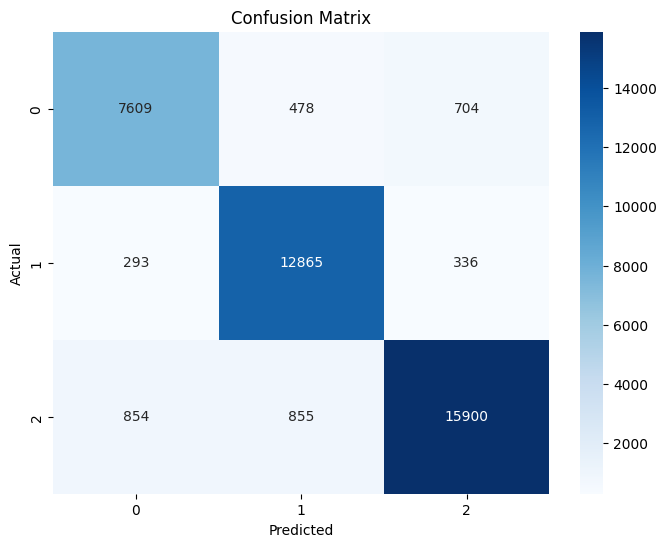

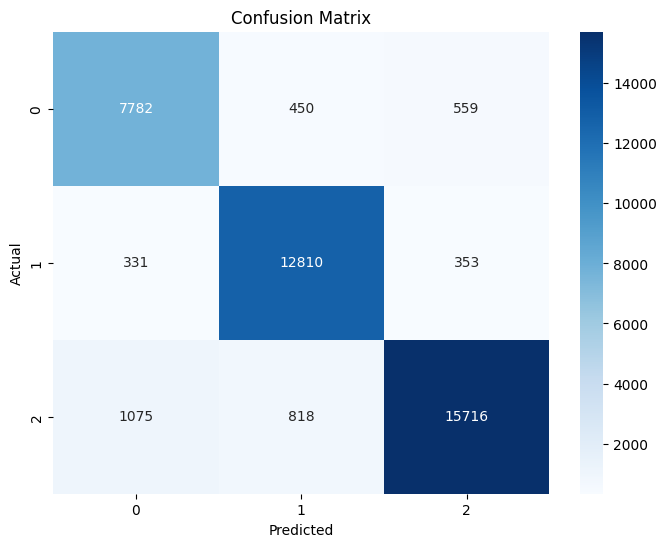

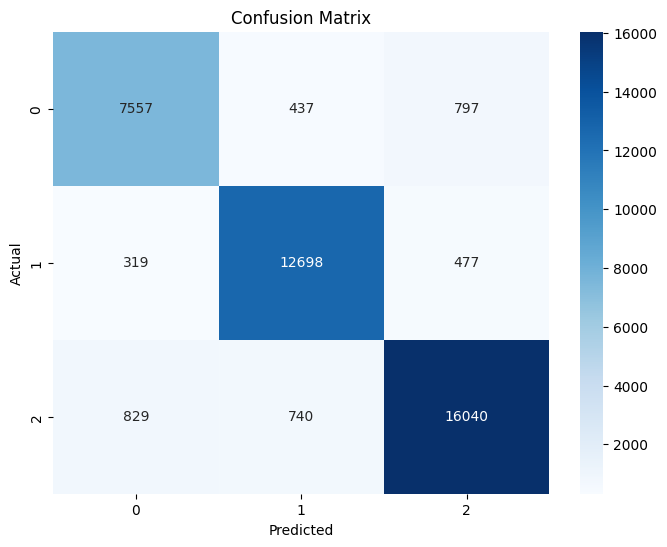

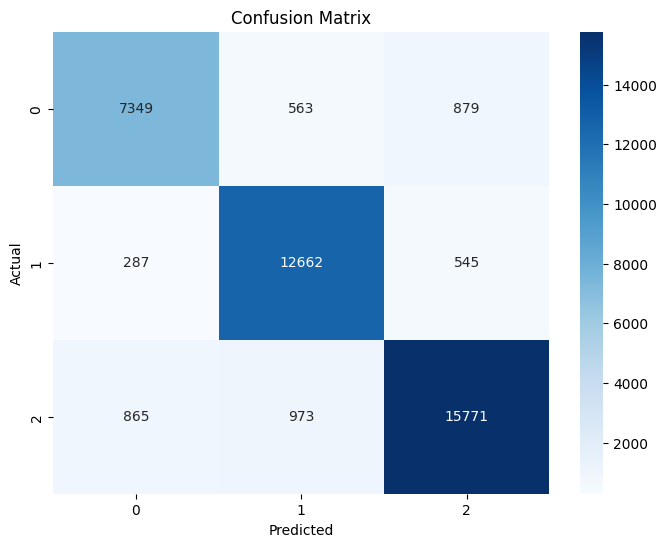

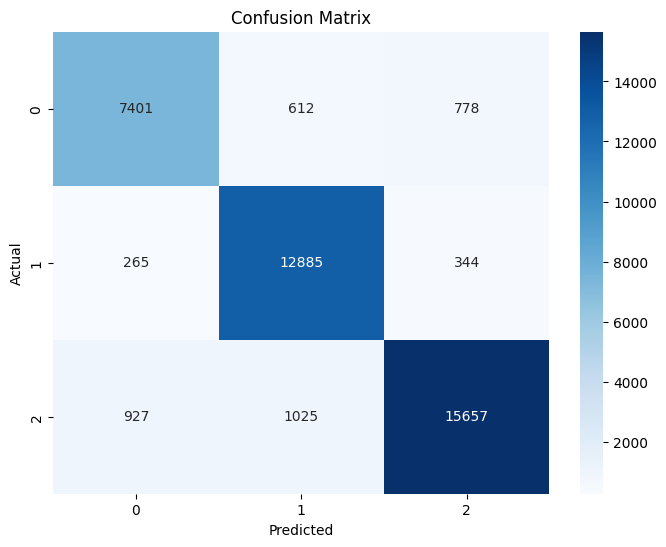

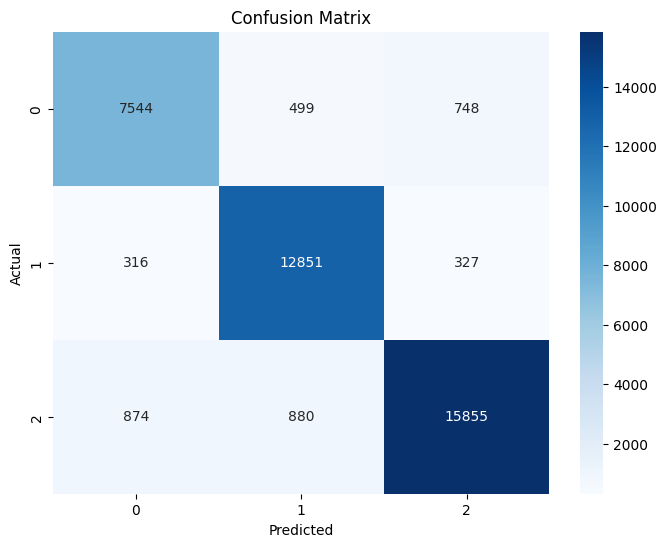

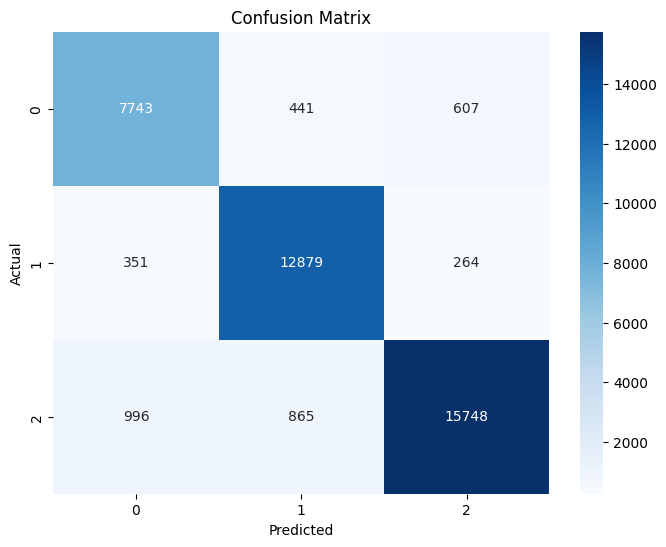

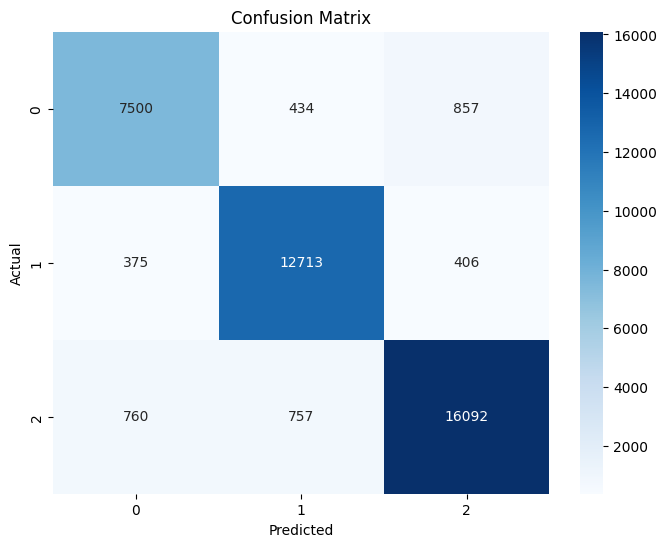

In [ ]:
# 9. Execute
best_study = run_optuna_study(n_trials=20)

In [ ]:
best_params1 = best_study.best_params

best_params2 = {
                'embed_dim': 100,
               'hidden_dim': 128,
               'learning_rate': 0.00274134071928009,
               'batch_size': 32
               }

In [ ]:
import mlflow
import mlflow.pytorch

def retrain_and_save_best_model(best_params, vocab, train_dataset, test_dataset, y_train, model_save_path="best_model.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Build model with best hyperparameters
    model = BiLSTMAttentionModel(
        vocab_size=len(vocab),
        embed_dim=best_params['embed_dim'],
        hidden_dim=best_params['hidden_dim'],
        output_dim=y_train.nunique()
    ).to(device)

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

    # DataLoaders with best batch_size
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=best_params['batch_size'])

    # Start MLflow run
    mlflow.set_experiment("BiLSTM Attention Best Model")
    with mlflow.start_run(run_name="Best_Model_Retrain"):
        # Log hyperparameters
        mlflow.log_params(best_params)

        # Train the model
        model = train_model(model, train_loader, test_loader, optimizer, criterion, device, trial_number="best")

        # Save locally
        torch.save(model.state_dict(), model_save_path)
        print(f"Best model retrained and saved as {model_save_path}.")

        # Log model to MLflow
        mlflow.pytorch.log_model(model, artifact_path="model")
        print("Best model logged to MLflow successfully.")

    return model
